# 🏎️ F1 Qualy Analysis & Predictions – GP Las Vegas 2025

Este notebook analiza el rendimiento de los pilotos en clasificación durante la temporada 2025
y lo compara con Las Vegas 2024. Después se entrena un modelo de Machine Learning sencillo
para predecir la parrilla de clasificación para el GP de Las Vegas 2025, incluyendo visualizaciones
antes y después del entrenamiento.



In [ ]:
!pip install fastf1 xgboost scikit-learn pandas numpy matplotlib

import os
import fastf1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Opcional: más bonito
plt.style.use('seaborn-v0_8')
sns.set()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = "/content/drive/MyDrive/f1_ml_project"
os.makedirs(f"{BASE_DIR}/cache", exist_ok=True)
os.makedirs(f"{BASE_DIR}/data", exist_ok=True)

fastf1.Cache.enable_cache(f"{BASE_DIR}/cache")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# --- Paleta oficial de colores F1 2025 ---
TEAM_COLORS = {
    'Mercedes': '#00D7B6',
    'Red Bull Racing': '#4781D7',
    'Ferrari': '#ED1131',
    'McLaren': '#F47600',
    'Alpine': '#00A1E8',
    'Racing Bulls': '#6C98FF',
    'Aston Martin': '#229971',
    'Williams': '#1868DB',
    'Kick Sauber': '#01C00E',
    'Haas F1 Team': '#9C9FA2',
    'Haas': '#9C9FA2'
}

def team_color_map(df, team_col='TeamName'):
    return df[team_col].map(TEAM_COLORS).fillna('#777777')


## 1. Descarga de datos de clasificación (2024 y 2025)

En esta sección descargamos los resultados de clasificación (Q) de:

- Temporada 2024 → para tener Las Vegas 2024 como referencia.
- Temporada 2025 → para medir la "forma" actual de cada piloto antes de Las Vegas 2025.

Después haremos visualizaciones exploratorias **antes de entrenar ningún modelo**.


In [ ]:
import fastf1

# Si usas Drive:
fastf1.Cache.enable_cache(f"{base_dir}/cache")

# Si pasas de Drive y quieres todo local en Colab:
# fastf1.Cache.enable_cache('./cache')


In [ ]:
import fastf1
import pandas as pd

year = 2024
gp_name = "Las Vegas"
session_type = "Q"  # clasificación

session = fastf1.get_session(year, gp_name, session_type)
session.load()

results = session.results

results[['Abbreviation', 'TeamName', 'Position', 'Q1', 'Q2', 'Q3']].head()



core           INFO 	Loading data for Las Vegas Grand Prix - Qualifying [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Las Vegas Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core           INFO 	Processing timing data...
INFO:fastf1.fastf1.core:Processing timing data...
req     

,Abbreviation,TeamName,Position,Q1,Q2,Q3
63,RUS,Mercedes,1.0,0 days 00:01:33.186000,0 days 00:01:32.779000,0 days 00:01:32.312000
55,SAI,Ferrari,2.0,0 days 00:01:33.484000,0 days 00:01:32.711000,0 days 00:01:32.410000
10,GAS,Alpine,3.0,0 days 00:01:33.691000,0 days 00:01:32.879000,0 days 00:01:32.664000
16,LEC,Ferrari,4.0,0 days 00:01:33.446000,0 days 00:01:33.016000,0 days 00:01:32.783000
1,VER,Red Bull Racing,5.0,0 days 00:01:33.299000,0 days 00:01:33.085000,0 days 00:01:32.797000


## 2. Análisis exploratorio de clasificación 2025 (antes del modelo)

Vamos a explorar:

- Distribución de posiciones de clasificación en 2025.
- Media de clasificación por piloto en 2025.
- Diferencias entre equipos.

Estas visualizaciones ayudan a entender el contexto antes de entrenar el modelo.


In [ ]:
import fastf1
import pandas as pd

def download_qualy_season(year):
    events = fastf1.get_event_schedule(year, include_testing=False)
    all_qualy = []

    for _, event in events.iterrows():
        event_name = event['EventName']
        round_number = event['RoundNumber']
        print(f"Cargando {year} - {event_name} (Ronda {round_number})...")

        try:
            session = fastf1.get_session(year, event_name, 'Q')
            session.load()

            df = session.results[['Abbreviation', 'TeamName', 'Position', 'Q1', 'Q2', 'Q3']].copy()
            df['Event'] = event_name
            df['Round'] = round_number
            df['Year'] = year

            all_qualy.append(df)
        except Exception as e:
            print(f"  ⚠️ No se pudo cargar {event_name}: {e}")

    if not all_qualy:
        raise ValueError(f"No se pudo descargar ninguna qualy para {year}")

    season_df = pd.concat(all_qualy, ignore_index=True)
    return season_df


In [ ]:
qualy_2024 = download_qualy_season(2024)
qualy_2025 = download_qualy_season(2025)

# Si estás usando Drive y base_dir:
qualy_2024.to_csv(f"{base_dir}/data/qualy_2024.csv", index=False)
qualy_2025.to_csv(f"{base_dir}/data/qualy_2025.csv", index=False)

qualy_2024.head(), qualy_2025.head()

core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Bahrain Grand Prix - Qualifying [v3.6.1]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...


Cargando 2024 - Bahrain Grand Prix (Ronda 1)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for track_status_data. Loading data...
_api  

Cargando 2024 - Saudi Arabian Grand Prix (Ronda 2)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached dat

Cargando 2024 - Australian Grand Prix (Ronda 3)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for track_status_data. Loading data...
_api  

Cargando 2024 - Japanese Grand Prix (Ronda 4)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for track_status_data. Loading data...
_api  

Cargando 2024 - Chinese Grand Prix (Ronda 5)...


INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to ca

Cargando 2024 - Miami Grand Prix (Ronda 6)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for track_status_data. Loading data...
_api  

Cargando 2024 - Emilia Romagna Grand Prix (Ronda 7)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.re

Cargando 2024 - Monaco Grand Prix (Ronda 8)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for track_status_data. Loading data...
_api  

Cargando 2024 - Canadian Grand Prix (Ronda 9)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for track_status_data. Loading data...
_api  

Cargando 2024 - Spanish Grand Prix (Ronda 10)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.re

Cargando 2024 - Austrian Grand Prix (Ronda 11)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for track_status_data. Loading data...
_api  

Cargando 2024 - British Grand Prix (Ronda 12)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for track_status_data. Loading data...
_api  

Cargando 2024 - Hungarian Grand Prix (Ronda 13)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for track_status_data. Loading data...
_api  

Cargando 2024 - Belgian Grand Prix (Ronda 14)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for track_status_data. Loading data...
_api  

Cargando 2024 - Dutch Grand Prix (Ronda 15)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached dat

Cargando 2024 - Italian Grand Prix (Ronda 16)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for track_status_data. Loading data...
_api  

Cargando 2024 - Azerbaijan Grand Prix (Ronda 17)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.re

Cargando 2024 - Singapore Grand Prix (Ronda 18)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached dat

Cargando 2024 - United States Grand Prix (Ronda 19)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached dat

Cargando 2024 - Mexico City Grand Prix (Ronda 20)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for track_status_data. Loading data...
_api  

Cargando 2024 - São Paulo Grand Prix (Ronda 21)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.re

Cargando 2024 - Las Vegas Grand Prix (Ronda 22)...


req            INFO 	Using cached data for car_data
INFO:fastf1.fastf1.req:Using cached data for car_data
req            INFO 	Using cached data for position_data
INFO:fastf1.fastf1.req:Using cached data for position_data
req            INFO 	Using cached data for weather_data
INFO:fastf1.fastf1.req:Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
INFO:fastf1.fastf1.req:Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['63', '55', '10', '16', '1', '4', '22', '81', '27', '44', '31', '20', '24', '43', '30', '11', '14', '23', '77', '18']
INFO:fastf1.fastf1.core:Finished loading data for 20 drivers: ['63', '55', '10', '16', '1', '4', '22', '81', '27', '44', '31', '20', '24', '43', '30', '11', '14', '23', '77', '18']
events      WARNING 	Correcting user input 'Qatar Grand Prix' to 'Qatar Grand Prix'
core           INFO 	Loading data for Qatar Grand Prix - Qualifying [v3.6.1]
INFO:fastf1.

Cargando 2024 - Qatar Grand Prix (Ronda 23)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for track_status_data. Loading data...
_api  

Cargando 2024 - Abu Dhabi Grand Prix (Ronda 24)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for track_status_data. Loading data...
_api  

Cargando 2025 - Australian Grand Prix (Ronda 1)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.re

Cargando 2025 - Chinese Grand Prix (Ronda 2)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for track_status_data. Loading data...
_api  

Cargando 2025 - Japanese Grand Prix (Ronda 3)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for track_status_data. Loading data...
_api  

Cargando 2025 - Bahrain Grand Prix (Ronda 4)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.re

Cargando 2025 - Saudi Arabian Grand Prix (Ronda 5)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.re

Cargando 2025 - Miami Grand Prix (Ronda 6)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for track_status_data. Loading data...
_api  

Cargando 2025 - Emilia Romagna Grand Prix (Ronda 7)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached dat

Cargando 2025 - Monaco Grand Prix (Ronda 8)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached dat

Cargando 2025 - Spanish Grand Prix (Ronda 9)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for track_status_data. Loading data...
_api  

Cargando 2025 - Canadian Grand Prix (Ronda 10)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for track_status_data. Loading data...
_api  

Cargando 2025 - Austrian Grand Prix (Ronda 11)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for track_status_data. Loading data...
_api  

Cargando 2025 - British Grand Prix (Ronda 12)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for track_status_data. Loading data...
_api  

Cargando 2025 - Belgian Grand Prix (Ronda 13)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for track_status_data. Loading data...
_api  

Cargando 2025 - Hungarian Grand Prix (Ronda 14)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for track_status_data. Loading data...
_api  

Cargando 2025 - Dutch Grand Prix (Ronda 15)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.re

Cargando 2025 - Italian Grand Prix (Ronda 16)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for track_status_data. Loading data...
_api  

Cargando 2025 - Azerbaijan Grand Prix (Ronda 17)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req   

Cargando 2025 - Singapore Grand Prix (Ronda 18)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req   

Cargando 2025 - United States Grand Prix (Ronda 19)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.re

Cargando 2025 - Mexico City Grand Prix (Ronda 20)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for track_status_data. Loading data...
_api  

Cargando 2025 - São Paulo Grand Prix (Ronda 21)...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for track_status_data. Loading data...
_api  

Cargando 2025 - Las Vegas Grand Prix (Ronda 22)...


core        WARNING 	Failed to load extended driver information!
DEBUG:fastf1.fastf1.core:Exception while loading driver list
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/fastf1/core.py", line 2406, in _drivers_from_f1_api
    f1di = api.driver_info(self.api_path, livedata=livedata)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastf1/req.py", line 479, in _cached_api_request
    data = func(api_path, **func_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastf1/_api.py", line 1560, in driver_info
    response = fetch_page(path, 'driver_list')
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastf1/_api.py", line 1752, in fetch_page
    r = Cache.requests_get(base_url + path + pages[name], headers=headers)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/

Cargando 2025 - Qatar Grand Prix (Ronda 23)...


logger      WARNING 	Failed to load session info data!
DEBUG:fastf1.fastf1.core:Traceback for failure in session info data
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/fastf1/logger.py", line 151, in __wrapped
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastf1/core.py", line 1471, in _load_session_info
    self._session_info = api.session_info(self.api_path,
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastf1/req.py", line 479, in _cached_api_request
    data = func(api_path, **func_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastf1/_api.py", line 1712, in session_info
    response = fetch_page(path, 'session_info')
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastf1/_api.py", line 1752, in fetch_page
    r = Cache.req

Cargando 2025 - Abu Dhabi Grand Prix (Ronda 24)...


logger      WARNING 	Failed to load session info data!
DEBUG:fastf1.fastf1.core:Traceback for failure in session info data
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/fastf1/logger.py", line 151, in __wrapped
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastf1/core.py", line 1471, in _load_session_info
    self._session_info = api.session_info(self.api_path,
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastf1/req.py", line 479, in _cached_api_request
    data = func(api_path, **func_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastf1/_api.py", line 1712, in session_info
    response = fetch_page(path, 'session_info')
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastf1/_api.py", line 1752, in fetch_page
    r = Cache.req

(  Abbreviation         TeamName  Position                     Q1  \
 0          VER  Red Bull Racing       1.0 0 days 00:01:30.031000   
 1          LEC          Ferrari       2.0 0 days 00:01:30.243000   
 2          RUS         Mercedes       3.0 0 days 00:01:30.350000   
 3          SAI          Ferrari       4.0 0 days 00:01:29.909000   
 4          PER  Red Bull Racing       5.0 0 days 00:01:30.221000   
 
                       Q2                     Q3               Event  Round  \
 0 0 days 00:01:29.374000 0 days 00:01:29.179000  Bahrain Grand Prix      1   
 1 0 days 00:01:29.165000 0 days 00:01:29.407000  Bahrain Grand Prix      1   
 2 0 days 00:01:29.922000 0 days 00:01:29.485000  Bahrain Grand Prix      1   
 3 0 days 00:01:29.573000 0 days 00:01:29.507000  Bahrain Grand Prix      1   
 4 0 days 00:01:29.932000 0 days 00:01:29.537000  Bahrain Grand Prix      1   
 
    Year  
 0  2024  
 1  2024  
 2  2024  
 3  2024  
 4  2024  ,
   Abbreviation         TeamName  Positio

In [ ]:
# Nos quedamos con 2025
q25 = qualy_2025.copy()

# Asegurar que Position es numérica
q25['Position'] = pd.to_numeric(q25['Position'], errors='coerce')
print("Filas con Position NaN:", q25['Position'].isna().sum())
q25 = q25.dropna(subset=['Position'])
q25['Position'] = q25['Position'].astype(int)

q25.head()


Filas con Position NaN: 1


/tmp/ipython-input-795501024.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q25['Position'] = q25['Position'].astype(int)


,Abbreviation,TeamName,Position,Q1,Q2,Q3,Event,Round,Year
0,NOR,McLaren,1,0 days 00:01:15.912000,0 days 00:01:15.415000,0 days 00:01:15.096000,Australian Grand Prix,1,2025
1,PIA,McLaren,2,0 days 00:01:16.062000,0 days 00:01:15.468000,0 days 00:01:15.180000,Australian Grand Prix,1,2025
2,VER,Red Bull Racing,3,0 days 00:01:16.018000,0 days 00:01:15.565000,0 days 00:01:15.481000,Australian Grand Prix,1,2025
3,RUS,Mercedes,4,0 days 00:01:15.971000,0 days 00:01:15.798000,0 days 00:01:15.546000,Australian Grand Prix,1,2025
4,TSU,Racing Bulls,5,0 days 00:01:16.225000,0 days 00:01:16.009000,0 days 00:01:15.670000,Australian Grand Prix,1,2025


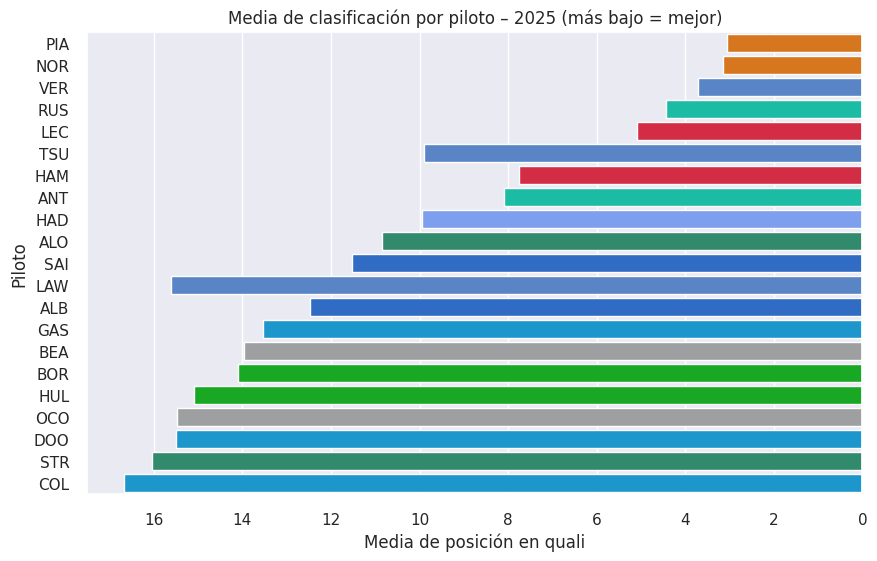

In [ ]:
# Paleta oficial F1 2025
TEAM_COLORS = {
    'Mercedes': '#00D7B6',
    'Red Bull Racing': '#4781D7',
    'Ferrari': '#ED1131',
    'McLaren': '#F47600',
    'Alpine': '#00A1E8',
    'Racing Bulls': '#6C98FF',
    'Aston Martin': '#229971',
    'Williams': '#1868DB',
    'Kick Sauber': '#01C00E',
    'Haas F1 Team': '#9C9FA2',
    'Haas': '#9C9FA2'
}

# DataFrame de medias
avg_quali_2025 = (
    q25.groupby(['Abbreviation', 'TeamName'])['Position']
       .mean()
       .reset_index()
       .rename(columns={'Position': 'avg_quali_2025'})
       .sort_values('avg_quali_2025')
)

# Diccionario piloto → color del equipo
pilot_colors = {
    row['Abbreviation']: TEAM_COLORS.get(row['TeamName'], '#777777')
    for _, row in avg_quali_2025.iterrows()
}

plt.figure(figsize=(10, 6))
sns.barplot(
    data=avg_quali_2025,
    x='avg_quali_2025',
    y='Abbreviation',
    hue='Abbreviation',          # usamos el piloto como hue
    palette=pilot_colors,        # mapeo piloto → color
    dodge=False,
    legend=False,                # quitamos leyenda duplicada
    errorbar=None                # sin barras negras de error
)

plt.title("Media de clasificación por piloto – 2025 (más bajo = mejor)")
plt.xlabel("Media de posición en quali")
plt.ylabel("Piloto")
plt.gca().invert_xaxis()
plt.show()


## 3. Construcción de features de "forma" de los pilotos

Definimos tres métricas de forma para cada piloto y cada ronda:

- `avg_quali_before`: media histórica de clasificación hasta la carrera anterior.
- `last3_avg_before`: media de las últimas 3 qualys antes de esa ronda.
- `trend_before`: tendencia (mejora/empeora) en las últimas 3 carreras.

Después haremos visualizaciones de estas métricas antes de entrenar el modelo.


In [ ]:
import pandas as pd

def build_season_features(qualy_df, year):
    df = qualy_df[qualy_df['Year'] == year].copy()

    # Convertimos Position a numérico, lo raro → NaN
    df['Position'] = pd.to_numeric(df['Position'], errors='coerce')

    # Quitamos filas sin posición válida
    n_nan = df['Position'].isna().sum()
    print(f"Eliminando {n_nan} filas con Position NaN para el año {year}")
    df = df.dropna(subset=['Position'])

    # Ya podemos convertir a int
    df['Position'] = df['Position'].astype(int)

    # ordenamos por piloto y ronda
    df = df.sort_values(['Abbreviation', 'Round'])

    # media de quali hasta la carrera anterior
    df['avg_quali_before'] = (
        df.groupby('Abbreviation')['Position']
          .apply(lambda x: x.shift().expanding().mean())
          .reset_index(level=0, drop=True)
    )

    # media de las últimas 3 qualys (antes de esta)
    df['last3_avg_before'] = (
        df.groupby('Abbreviation')['Position']
          .apply(lambda x: x.shift().rolling(3, min_periods=1).mean())
          .reset_index(level=0, drop=True)
    )

    # tendencia: mejora/empeora en las últimas 3
    df['trend_before'] = (
        df.groupby('Abbreviation')['Position']
          .apply(lambda x: x.shift().diff().rolling(3, min_periods=1).mean())
          .reset_index(level=0, drop=True)
    )

    return df

features_2025 = build_season_features(qualy_2025, 2025)
features_2025.head()


Eliminando 1 filas con Position NaN para el año 2025


/tmp/ipython-input-2287083138.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Position'] = df['Position'].astype(int)


,Abbreviation,TeamName,Position,Q1,Q2,Q3,Event,Round,Year,avg_quali_before,last3_avg_before,trend_before
5,ALB,Williams,6,0 days 00:01:16.245000,0 days 00:01:16.017000,0 days 00:01:15.737000,Australian Grand Prix,1,2025,NaN,NaN,NaN
29,ALB,Williams,10,0 days 00:01:31.503000,0 days 00:01:31.595000,0 days 00:01:31.706000,Chinese Grand Prix,2,2025,6.000000,6.000000,NaN
48,ALB,Williams,9,0 days 00:01:28.218000,0 days 00:01:27.783000,0 days 00:01:27.615000,Japanese Grand Prix,3,2025,8.000000,8.000000,4.0
74,ALB,Williams,15,0 days 00:01:32.040000,NaT,NaT,Bahrain Grand Prix,4,2025,8.333333,8.333333,1.5
90,ALB,Williams,11,0 days 00:01:28.279000,0 days 00:01:28.109000,NaT,Saudi Arabian Grand Prix,5,2025,10.000000,11.333333,3.0


In [ ]:
# features_2025 ya lo tienes creado con build_season_features

# Último registro disponible por piloto en 2025
current_form_2025 = (
    features_2025
    .sort_values(['Abbreviation', 'Round'])
    .groupby('Abbreviation')
    .tail(1)
    .reset_index(drop=True)
)

current_form_2025[['Abbreviation', 'TeamName', 'Round',
                   'avg_quali_before', 'last3_avg_before', 'trend_before']].head()


,Abbreviation,TeamName,Round,avg_quali_before,last3_avg_before,trend_before
0,ALB,Williams,21,12.50,18.333333,-0.666667
1,ALO,Aston Martin,21,10.85,11.333333,1.000000
2,ANT,Mercedes,21,8.40,5.666667,0.666667
3,BEA,Haas F1 Team,21,14.25,9.000000,-1.666667
4,BOR,Kick Sauber,20,14.00,14.333333,2.666667


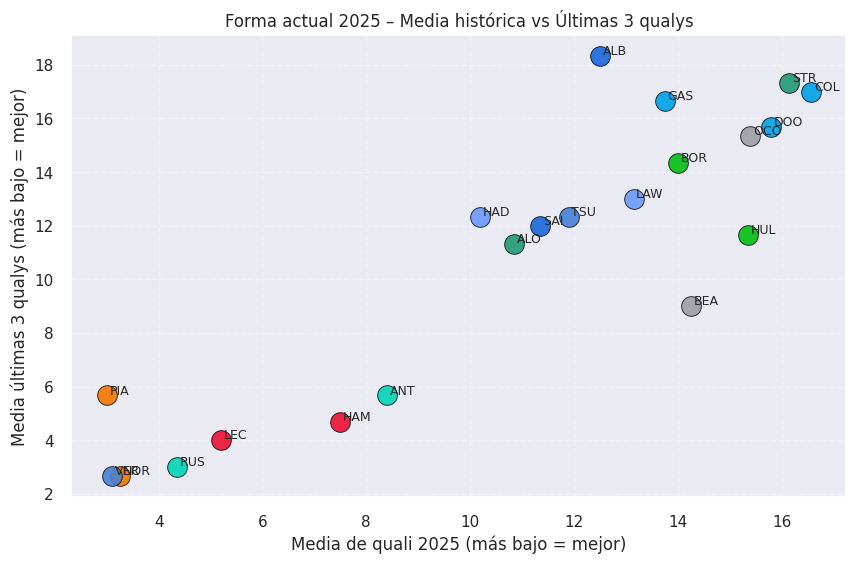

In [ ]:
plt.figure(figsize=(10, 6))

# Pintamos cada piloto con su color de equipo
for _, r in current_form_2025.iterrows():
    plt.scatter(
        r['avg_quali_before'],
        r['last3_avg_before'],
        s=200,                                    # tamaño del punto
        color=TEAM_COLORS.get(r['TeamName'], '#777777'),
        edgecolor='black',
        linewidth=0.6,
        alpha=0.9
    )
    plt.text(
        r['avg_quali_before'] + 0.05,
        r['last3_avg_before'] + 0.05,
        r['Abbreviation'],
        fontsize=9
    )

plt.title("Forma actual 2025 – Media histórica vs Últimas 3 qualys")
plt.xlabel("Media de quali 2025 (más bajo = mejor)")
plt.ylabel("Media últimas 3 qualys (más bajo = mejor)")
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()


In [ ]:
# Asegúrate de tener qualy_2024 creado
# qualy_2024 = download_qualy_season(2024)  ← esto ya lo hiciste antes, no lo repitas ahora si estás rate-limited

lv_2024 = qualy_2024[
    (qualy_2024['Year'] == 2024) &
    (qualy_2024['Event'].str.contains("Las Vegas", case=False))
].copy()

lv_2024 = lv_2024.rename(columns={'Position': 'las_vegas_2024_position'})
lv_2024[['Abbreviation', 'TeamName', 'las_vegas_2024_position']].head()


,Abbreviation,TeamName,las_vegas_2024_position
419,RUS,Mercedes,1.0
420,SAI,Ferrari,2.0
421,GAS,Alpine,3.0
422,LEC,Ferrari,4.0
423,VER,Red Bull Racing,5.0


In [ ]:
# Último registro disponible en 2025 por piloto (forma actual)
current_form_2025 = (
    features_2025
    .sort_values(['Abbreviation', 'Round'])
    .groupby('Abbreviation')
    .tail(1)
    .reset_index(drop=True)
)

summary = current_form_2025.merge(
    lv_2024[['Abbreviation', 'las_vegas_2024_position']],
    on='Abbreviation',
    how='left'
)

cols = [
    'Abbreviation',
    'TeamName',
    'Round',
    'avg_quali_before',
    'last3_avg_before',
    'trend_before',
    'las_vegas_2024_position'
]

summary[cols].sort_values('avg_quali_before')


,Abbreviation,TeamName,Round,avg_quali_before,last3_avg_before,trend_before,las_vegas_2024_position
15,PIA,McLaren,21,3.000000,5.666667,-0.333333,8.0
20,VER,Red Bull Racing,21,3.100000,2.666667,1.333333,5.0
13,NOR,McLaren,21,3.250000,2.666667,-2.000000,6.0
16,RUS,Mercedes,21,4.350000,3.000000,-0.333333,1.0
12,LEC,Ferrari,21,5.200000,4.000000,-2.666667,4.0
9,HAM,Ferrari,21,7.500000,4.666667,-3.000000,10.0
2,ANT,Mercedes,21,8.400000,5.666667,0.666667,NaN
8,HAD,Racing Bulls,21,10.200000,12.333333,0.333333,NaN
1,ALO,Aston Martin,21,10.850000,11.333333,1.000000,17.0
17,SAI,Williams,21,11.350000,12.000000,1.666667,2.0


## 4. Entrenamiento de un modelo de predicción de clasificación

Entrenamos un modelo XGBoost Regresor que intenta predecir la posición de clasificación
a partir de las métricas de forma:

- `avg_quali_before`
- `last3_avg_before`
- `trend_before`

Usamos datos de 2025 (todas las rondas donde estas features están definidas).


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

train_df = features_2025.dropna(subset=['avg_quali_before', 'last3_avg_before', 'trend_before']).copy()

feature_cols = ['avg_quali_before', 'last3_avg_before', 'trend_before']

X = train_df[feature_cols]
y = train_df['Position']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='reg:squarederror'
)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print(f"MAE (error medio en posiciones): {mae:.2f}")


MAE (error medio en posiciones): 3.60


## 5. Predicción de clasificación para GP de Las Vegas 2025

Usamos la forma actual de cada piloto (`current_form_2025`) como input al modelo
para estimar su posición en clasificación en Las Vegas 2025.

Después generamos visualizaciones específicas de estas predicciones.


In [ ]:
X_pred = current_form_2025[feature_cols].copy()
current_form_2025['predicted_quali_position'] = model.predict(X_pred)

summary_pred = current_form_2025.sort_values('predicted_quali_position').copy()
summary_pred['predicted_quali_P'] = summary_pred['predicted_quali_position'].round().astype(int)

summary_pred[['predicted_quali_P', 'Abbreviation', 'TeamName',
              'avg_quali_before', 'last3_avg_before', 'trend_before']].head(20)


,predicted_quali_P,Abbreviation,TeamName,avg_quali_before,last3_avg_before,trend_before
13,2,NOR,McLaren,3.250000,2.666667,-2.000000
15,4,PIA,McLaren,3.000000,5.666667,-0.333333
16,5,RUS,Mercedes,4.350000,3.000000,-0.333333
12,5,LEC,Ferrari,5.200000,4.000000,-2.666667
11,9,LAW,Racing Bulls,13.150000,13.000000,4.000000
3,10,BEA,Haas F1 Team,14.250000,9.000000,-1.666667
2,10,ANT,Mercedes,8.400000,5.666667,0.666667
1,10,ALO,Aston Martin,10.850000,11.333333,1.000000
10,11,HUL,Kick Sauber,15.350000,11.666667,-1.333333
9,11,HAM,Ferrari,7.500000,4.666667,-3.000000


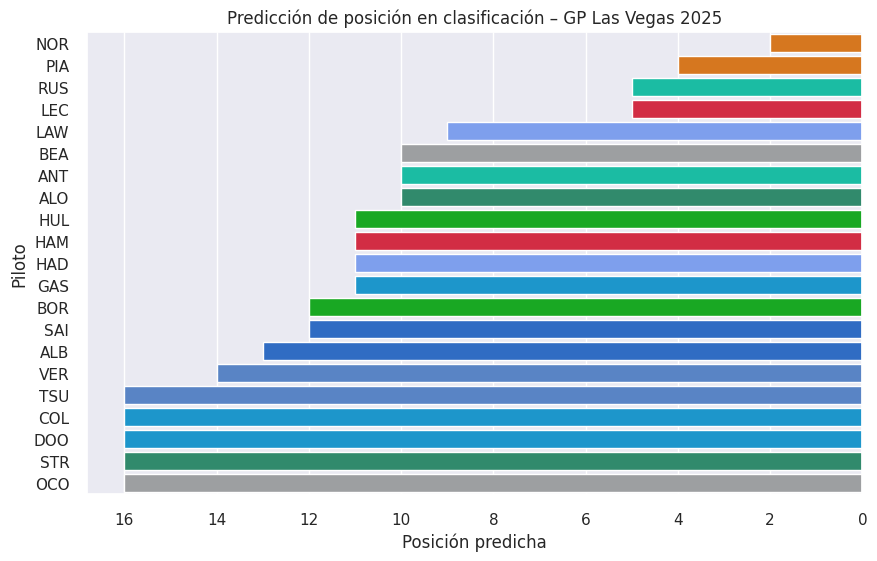

In [ ]:
# Diccionario piloto → color del equipo (igual que antes)
pred_colors = {
    row['Abbreviation']: TEAM_COLORS.get(row['TeamName'], '#777777')
    for _, row in summary_pred.iterrows()
}

plt.figure(figsize=(10, 6))
sns.barplot(
    data=summary_pred,
    x='predicted_quali_P',
    y='Abbreviation',
    hue='Abbreviation',          # usamos piloto como hue para permitir mapa 1:1
    palette=pred_colors,         # asignamos color exacto por piloto/equipo
    dodge=False,
    legend=False,                # evitamos texto duplicado y líos de seaborn
    errorbar=None                # evita barras negras horizontales
)

plt.title("Predicción de posición en clasificación – GP Las Vegas 2025")
plt.xlabel("Posición predicha")
plt.ylabel("Piloto")
plt.gca().invert_xaxis()         # P1 a la derecha
plt.show()


## 5. Modelo mejorado (2024 + 2025) y preparación para eventos de carrera

En este paso:
- Unimos las temporadas 2024 y 2025 para entrenar el modelo con más datos.
- Creamos nuevas features:
  - `team_avg_before`: nivel medio del equipo.
  - `delta_vs_team`: diferencia del piloto frente al rendimiento medio del coche.
- Entrenamos un XGBoost mejorado y calculamos un nuevo MAE.
- Dejamos preparado el flujo para, en una sección aparte, estimar
  probabilidades de:
  - Safety Car (SC)
  - Bandera roja
para cada Gran Premio a partir de los mensajes de dirección de carrera.


In [ ]:

features_2024 = build_season_features(qualy_2024, 2024)

Eliminando 0 filas con Position NaN para el año 2024


In [ ]:
# Si no lo tienes ya:
# features_2024 = build_season_features(qualy_2024, 2024)
# features_2025 = build_season_features(qualy_2025, 2025)

features_all = pd.concat([features_2024, features_2025], ignore_index=True)

# Ordenamos por año, equipo y ronda
features_all = features_all.sort_values(['Year', 'TeamName', 'Round']).reset_index(drop=True)

# Media histórica de clasificación del equipo hasta la ronda anterior
features_all['team_avg_before'] = (
    features_all
    .groupby(['Year', 'TeamName'])['Position']
    .apply(lambda x: x.shift().expanding().mean())
    .reset_index(level=[0,1], drop=True)
)

# Diferencia piloto vs equipo (negativo = mejor que la media del coche)
features_all['delta_vs_team'] = features_all['avg_quali_before'] - features_all['team_avg_before']

features_all[['Year','Round','Abbreviation','TeamName',
              'avg_quali_before','team_avg_before','delta_vs_team']].head(10)


,Year,Round,Abbreviation,TeamName,avg_quali_before,team_avg_before,delta_vs_team
0,2024,1,GAS,Alpine,NaN,NaN,NaN
1,2024,1,OCO,Alpine,NaN,20.000000,NaN
2,2024,2,GAS,Alpine,20.000000,19.500000,0.500000
3,2024,2,OCO,Alpine,19.000000,19.000000,0.000000
4,2024,3,GAS,Alpine,19.000000,18.500000,0.500000
5,2024,3,OCO,Alpine,18.000000,18.200000,-0.200000
6,2024,4,GAS,Alpine,18.333333,17.666667,0.666667
7,2024,4,OCO,Alpine,17.000000,17.571429,-0.571429
8,2024,5,GAS,Alpine,18.000000,17.250000,0.750000
9,2024,5,OCO,Alpine,16.500000,17.000000,-0.500000


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

# Filas donde todas las features estén bien definidas
train_df2 = features_all.dropna(
    subset=['avg_quali_before', 'last3_avg_before', 'trend_before',
            'team_avg_before', 'delta_vs_team']
).copy()

feature_cols2 = [
    'avg_quali_before',
    'last3_avg_before',
    'trend_before',
    'team_avg_before',
    'delta_vs_team'
]

X2 = train_df2[feature_cols2]
y2 = train_df2['Position']

X2_train, X2_val, y2_train, y2_val = train_test_split(
    X2, y2, test_size=0.2, random_state=42
)

model2 = xgb.XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    objective='reg:squarederror'
)

# Entrenamos SIN early stopping (versión compatible)
model2.fit(
    X2_train, y2_train,
    eval_set=[(X2_val, y2_val)],
    verbose=False
)

y2_pred = model2.predict(X2_val)
mae2 = mean_absolute_error(y2_val, y2_pred)
print(f"MAE nuevo (2024+2025, 5 features): {mae2:.2f}")


MAE nuevo (2024+2025, 5 features): 3.49


## 6. Modelo v2 (7 features) – añadiendo tipo de circuito y progreso de temporada

En esta sección no tocamos el modelo anterior (v1, 5 features, MAE ~3.49).

Creamos un segundo modelo:

- Reutilizamos `features_all` para derivar `features_all_v2`
- Añadimos:
  - `is_street`: indicador de circuito urbano
  - `season_progress`: progreso de temporada (Round / total de rondas del año)
- Entrenamos `model3` y calculamos `mae3` para compararlo con `mae2`.


In [ ]:
# Partimos de features_all SIN modificarlo
features_all_v2 = features_all.copy()

# Lista de circuitos urbanos aproximada (ajústala si quieres afinar)
street_keywords = ['Las Vegas', 'Miami', 'Azerbaijan', 'Baku', 'Singapore', 'Jeddah', 'Saudi', 'Monaco']

def is_street(event_name):
    name = str(event_name)
    return int(any(k.lower() in name.lower() for k in street_keywords))

# Tipo de circuito: urbano o no
features_all_v2['is_street'] = features_all_v2['Event'].apply(is_street)

# Progreso de temporada: Round / máximo Round por Year
max_rounds = features_all_v2.groupby('Year')['Round'].transform('max')
features_all_v2['season_progress'] = features_all_v2['Round'] / max_rounds

features_all_v2[['Year','Event','Round','is_street','season_progress']].head(10)


,Year,Event,Round,is_street,season_progress
0,2024,Bahrain Grand Prix,1,0,0.041667
1,2024,Bahrain Grand Prix,1,0,0.041667
2,2024,Saudi Arabian Grand Prix,2,1,0.083333
3,2024,Saudi Arabian Grand Prix,2,1,0.083333
4,2024,Australian Grand Prix,3,0,0.125000
5,2024,Australian Grand Prix,3,0,0.125000
6,2024,Japanese Grand Prix,4,0,0.166667
7,2024,Japanese Grand Prix,4,0,0.166667
8,2024,Chinese Grand Prix,5,0,0.208333
9,2024,Chinese Grand Prix,5,0,0.208333


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

# Filtramos filas con todas las features definidas
train_df3 = features_all_v2.dropna(
    subset=[
        'avg_quali_before', 'last3_avg_before', 'trend_before',
        'team_avg_before', 'delta_vs_team',
        'is_street', 'season_progress'
    ]
).copy()

feature_cols3 = [
    'avg_quali_before',
    'last3_avg_before',
    'trend_before',
    'team_avg_before',
    'delta_vs_team',
    'is_street',
    'season_progress'
]

X3 = train_df3[feature_cols3]
y3 = train_df3['Position']

X3_train, X3_val, y3_train, y3_val = train_test_split(
    X3, y3, test_size=0.2, random_state=42
)

model3 = xgb.XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    objective='reg:squarederror'
)

model3.fit(
    X3_train, y3_train,
    eval_set=[(X3_val, y3_val)],
    verbose=False
)

y3_pred = model3.predict(X3_val)
mae3 = mean_absolute_error(y3_val, y3_pred)

print(f"MAE v1 (5 features – model2): {mae2:.2f}")
print(f"MAE v2 (7 features – model3): {mae3:.2f}")


MAE v1 (5 features – model2): 3.49
MAE v2 (7 features – model3): 3.58


In [ ]:
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import pandas as pd

configs = [
    {
        'name': 'v2_base',
        'params': dict(
            n_estimators=600,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            reg_alpha=0.0
        )
    },
    {
        'name': 'v2_shallower_more_trees',  # árboles más bajos, más robusto
        'params': dict(
            n_estimators=800,
            learning_rate=0.04,
            max_depth=4,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.5,
            reg_alpha=0.1
        )
    },
    {
        'name': 'v2_shallow_strong_reg',   # aún más regularización
        'params': dict(
            n_estimators=600,
            learning_rate=0.05,
            max_depth=3,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=2.0,
            reg_alpha=0.2
        )
    },
    {
        'name': 'v2_fast_lr',              # lr más alta, menos árboles
            # cuidado: puede overfit rápido
        'params': dict(
            n_estimators=300,
            learning_rate=0.10,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            reg_alpha=0.0
        )
    }
]

results_tuning = []

for cfg in configs:
    print(f"Entrenando {cfg['name']}...")
    m = xgb.XGBRegressor(
        objective='reg:squarederror',
        **cfg['params']
    )
    m.fit(
        X3_train, y3_train,
        eval_set=[(X3_val, y3_val)],
        verbose=False
    )
    preds = m.predict(X3_val)
    mae_cfg = mean_absolute_error(y3_val, preds)
    results_tuning.append({
        'model_name': cfg['name'],
        'MAE': mae_cfg,
        'params': cfg['params'],
        'model_obj': m
    })

tuning_df = pd.DataFrame(
    [{'model_name': r['model_name'], 'MAE': r['MAE']} for r in results_tuning]
).sort_values('MAE')

tuning_df


Entrenando v2_base...
Entrenando v2_shallower_more_trees...
Entrenando v2_shallow_strong_reg...
Entrenando v2_fast_lr...


,model_name,MAE
2,v2_shallow_strong_reg,3.549703
3,v2_fast_lr,3.581949
0,v2_base,3.584716
1,v2_shallower_more_trees,3.630548


In [ ]:
best_row = min(results_tuning, key=lambda r: r['MAE'])
model3_best = best_row['model_obj']
mae3_best = best_row['MAE']

print("Mejor configuración v2:")
print("Nombre:", best_row['model_name'])
print("MAE:", mae3_best)
print("Parámetros:", best_row['params'])


Mejor configuración v2:
Nombre: v2_shallow_strong_reg
MAE: 3.5497026443481445
Parámetros: {'n_estimators': 600, 'learning_rate': 0.05, 'max_depth': 3, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_lambda': 2.0, 'reg_alpha': 0.2}


In [ ]:
results = pd.DataFrame([
    {
        'model': 'v1 – 5 features',
        'features': 'avg_quali_before, last3_avg_before, trend_before, team_avg_before, delta_vs_team',
        'MAE': mae2
    },
    {
        'model': 'v2 – 7 features',
        'features': 'v1 + is_street, season_progress',
        'MAE': mae3
    }
])

results


,model,features,MAE
0,v1 – 5 features,"avg_quali_before, last3_avg_before, trend_befo...",3.488705
1,v2 – 7 features,"v1 + is_street, season_progress",3.584716


In [ ]:
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import pandas as pd

configs_v1 = [
    {
        'name': 'v1_base',
        'params': dict(
            n_estimators=600,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            reg_alpha=0.0
        )
    },
    {
        'name': 'v1_shallower_more_trees',
        'params': dict(
            n_estimators=900,
            learning_rate=0.03,
            max_depth=4,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.3,
            reg_alpha=0.05
        )
    },
    {
        'name': 'v1_strong_reg',
        'params': dict(
            n_estimators=600,
            learning_rate=0.05,
            max_depth=3,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=2.0,
            reg_alpha=0.2
        )
    },
    {
        'name': 'v1_fast_lr',
        'params': dict(
            n_estimators=300,
            learning_rate=0.10,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            reg_alpha=0.0
        )
    }
]

results_tuning_v1 = []

print("=== TUNING MODELO v1 ===")

for cfg in configs_v1:
    print(f"Entrenando {cfg['name']}...")
    m = xgb.XGBRegressor(
        objective='reg:squarederror',
        **cfg['params']
    )
    m.fit(
        X2_train, y2_train,
        eval_set=[(X2_val, y2_val)],
        verbose=False
    )
    preds = m.predict(X2_val)
    mae_cfg = mean_absolute_error(y2_val, preds)
    results_tuning_v1.append({
        'model_name': cfg['name'],
        'MAE': mae_cfg,
        'params': cfg['params'],
        'model_obj': m
    })

tuning_v1_df = pd.DataFrame(
    [{'model_name': r['model_name'], 'MAE': r['MAE']} for r in results_tuning_v1]
).sort_values('MAE')

tuning_v1_df


=== TUNING MODELO v1 ===
Entrenando v1_base...
Entrenando v1_shallower_more_trees...
Entrenando v1_strong_reg...
Entrenando v1_fast_lr...


,model_name,MAE
2,v1_strong_reg,3.378508
3,v1_fast_lr,3.392294
1,v1_shallower_more_trees,3.427169
0,v1_base,3.488705


In [ ]:
model1_best = results_tuning_v1[0]['model_obj']
mae1_best = results_tuning_v1[0]['MAE']


In [ ]:
# Elegimos el mejor modelo del tuning v1
best_row_v1 = min(results_tuning_v1, key=lambda r: r['MAE'])
model1_best = best_row_v1['model_obj']
mae1_best = best_row_v1['MAE']

print("🔝 MODELO OFICIAL – v1_best")
print("Nombre:", best_row_v1['model_name'])
print("MAE:", mae1_best)
print("Parámetros:", best_row_v1['params'])


🔝 MODELO OFICIAL – v1_best
Nombre: v1_strong_reg
MAE: 3.3785083293914795
Parámetros: {'n_estimators': 600, 'learning_rate': 0.05, 'max_depth': 3, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_lambda': 2.0, 'reg_alpha': 0.2}


## 📊 Comparativa de Modelos de Predicción de Clasificación F1 (2024–2025)

En este proyecto se han evaluado dos familias de modelos para predecir la posición de clasificación de cada piloto:

---

### 🔵 **Modelo v1 – 5 features (forma del piloto + nivel del equipo)**  
Incluye:  
- `avg_quali_before`  
- `last3_avg_before`  
- `trend_before`  
- `team_avg_before`  
- `delta_vs_team`

**Resultados:**  
- MAE inicial: **3.49**  
- MAE optimizado (tuning): **3.38** → 🏆 *Mejor resultado global*

---

### 🟣 **Modelo v2 – 7 features (v1 + tipo de circuito + progreso de temporada)**  
Añade:  
- `is_street`  
- `season_progress`

**Resultados:**  
- MAE entre **3.55 y 3.63** según configuración  
- No consigue superar al modelo v1

---

## 🏁 **Conclusión General**

- El **modelo v1 optimizado (MAE = 3.38)** es el más preciso y estable.  
- El modelo v2 aporta experimentación interesante, pero introduce ruido y no mejora la predicción.  
- Para las predicciones finales del **GP de Las Vegas 2025**, el modelo oficial será:  
  **👉 `model1_best` (v1 optimizado)**

---

## 📈 Visualizaciones Comparativas
Debajo encontrarás gráficos comparativos del MAE entre modelos evaluados.


/tmp/ipython-input-4271543801.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mae_df, x='Modelo', y='MAE', palette='viridis')


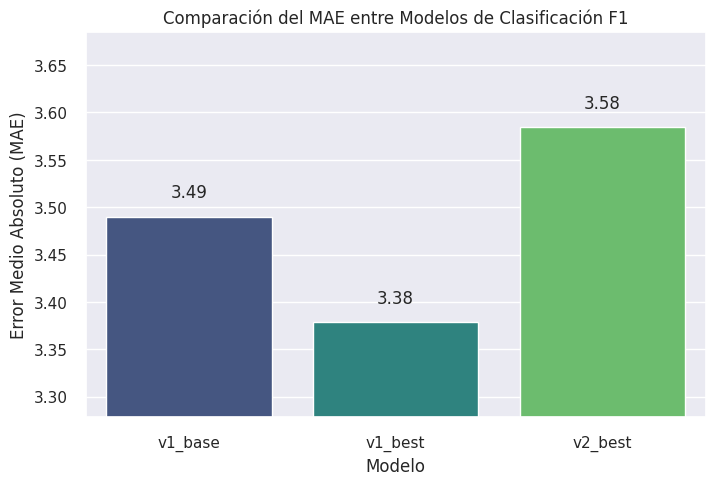

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Datos de los modelos evaluados
mae_models = {
    'v1_base': 3.49,
    'v1_best': mae1_best,              # ~3.38
    'v2_best': mae3,                   # ~3.55 (o el mejor de v2)
}

mae_df = pd.DataFrame({
    'Modelo': mae_models.keys(),
    'MAE': mae_models.values()
})

plt.figure(figsize=(8, 5))
sns.barplot(data=mae_df, x='Modelo', y='MAE', palette='viridis')

plt.title("Comparación del MAE entre Modelos de Clasificación F1")
plt.ylabel("Error Medio Absoluto (MAE)")
plt.xlabel("Modelo")
plt.ylim(min(mae_df['MAE']) - 0.1, max(mae_df['MAE']) + 0.1)

for index, row in mae_df.iterrows():
    plt.text(index, row['MAE'] + 0.02, f"{row['MAE']:.2f}", ha='center')

plt.show()


/tmp/ipython-input-3236432238.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


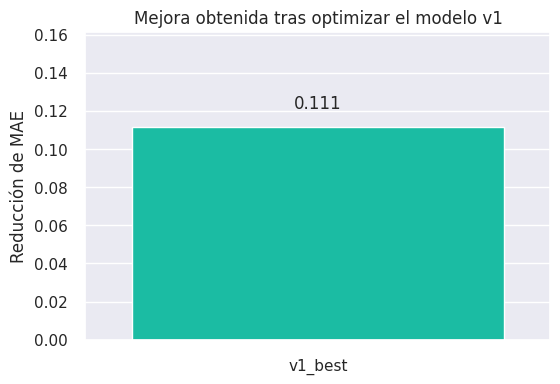

In [ ]:
improvement_df = pd.DataFrame({
    'Modelo': ['v1_best'],
    'Mejora_vs_v1_base': [mae_models['v1_base'] - mae_models['v1_best']]
})

plt.figure(figsize=(6, 4))
sns.barplot(
    data=improvement_df,
    x='Modelo',
    y='Mejora_vs_v1_base',
    palette=['#00D7B6']  # color Mercedes porque ha ganado el tuning 😄
)

plt.title("Mejora obtenida tras optimizar el modelo v1")
plt.ylabel("Reducción de MAE")
plt.xlabel("")
plt.ylim(0, improvement_df['Mejora_vs_v1_base'].max() + 0.05)

for index, row in improvement_df.iterrows():
    plt.text(
        index,
        row['Mejora_vs_v1_base'] + 0.01,
        f"{row['Mejora_vs_v1_base']:.3f}",
        ha='center'
    )

plt.show()


## 6. Backtest: GP de São Paulo 2025 con `model1_best`

Antes de usar el modelo para predecir el GP de Las Vegas 2025, realizamos una validación
“tipo backtest” en el GP de São Paulo 2025:

- Usamos únicamente la **información disponible antes de São Paulo 2025**  
  (forma del piloto, media de equipo, diferencia piloto–equipo, etc.).
- Generamos la **predicción de clasificación para cada piloto** en São Paulo.
- Comparamos con el resultado real de la qualy:
  - Calculamos el MAE específico del GP.
  - Medimos el **% de pilotos predichos con un error ≤ 2 posiciones**.
  - Vemos aciertos en la zona alta de la parrilla.

Este paso sirve para comprobar cómo de bien generaliza el modelo en un caso real cuyo
resultado ya conocemos.


In [ ]:
# 1) Localizar la ronda de São Paulo 2025 en features_all (o features_2025)
brazil_mask = features_all['Year'].eq(2025) & features_all['Event'].str.contains("São Paulo", case=False)
brazil_round = features_all.loc[brazil_mask, 'Round'].iloc[0]
print("Ronda de São Paulo 2025:", brazil_round)

# 2) Usamos solo carreras ANTERIORES a São Paulo para construir la forma
feat_2025_for_brazil = features_all[features_all['Year'] == 2025].copy()
feat_2025_for_brazil = feat_2025_for_brazil[feat_2025_for_brazil['Round'] < brazil_round]

# Por seguridad, ordenamos
feat_2025_for_brazil = feat_2025_for_brazil.sort_values(['Abbreviation', 'Round'])

# 3) Último registro disponible antes de São Paulo por piloto
brazil_snapshot = (
    feat_2025_for_brazil
    .groupby('Abbreviation')
    .tail(1)
    .reset_index(drop=True)
)

brazil_snapshot[['Abbreviation','TeamName','Round',
                 'avg_quali_before','last3_avg_before',
                 'trend_before','team_avg_before','delta_vs_team']].head()


Ronda de São Paulo 2025: 21


,Abbreviation,TeamName,Round,avg_quali_before,last3_avg_before,trend_before,team_avg_before,delta_vs_team
0,ALB,Williams,20,12.263158,19.000000,1.666667,11.921053,0.342105
1,ALO,Aston Martin,20,10.684211,10.333333,0.333333,13.342105,-2.657895
2,ANT,Mercedes,20,8.526316,5.000000,0.000000,6.447368,2.078947
3,BEA,Haas F1 Team,20,14.473684,10.666667,-1.000000,15.026316,-0.552632
4,BOR,Kick Sauber,20,14.000000,14.333333,2.666667,14.736842,-0.736842


In [ ]:
# 4) Resultados reales de clasificación en São Paulo 2025
brazil_quali_real = qualy_2025[qualy_2025['Event'].str.contains("São Paulo", case=False)].copy()

brazil_quali_real['Position'] = pd.to_numeric(brazil_quali_real['Position'], errors='coerce')
brazil_quali_real = brazil_quali_real.dropna(subset=['Position'])
brazil_quali_real['Position'] = brazil_quali_real['Position'].astype(int)

brazil_quali_real = brazil_quali_real[['Abbreviation', 'TeamName', 'Position']]
brazil_quali_real.sort_by = 'Position'
brazil_quali_real.head()


/tmp/ipython-input-1263084975.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brazil_quali_real['Position'] = brazil_quali_real['Position'].astype(int)


,Abbreviation,TeamName,Position
400,NOR,McLaren,1
401,ANT,Mercedes,2
402,LEC,Ferrari,3
403,PIA,McLaren,4
404,HAD,Racing Bulls,5


In [ ]:
# Features del modelo oficial
feature_cols_best = [
    'avg_quali_before',
    'last3_avg_before',
    'trend_before',
    'team_avg_before',
    'delta_vs_team'
]

# 1) Predicción de clasificación para São Paulo 2025 usando el snapshot previo
X_brazil = brazil_snapshot[feature_cols_best].copy()
brazil_snapshot['predicted_quali_position'] = model1_best.predict(X_brazil)
brazil_snapshot['predicted_quali_P'] = brazil_snapshot['predicted_quali_position'].round().astype(int)

# 2) Resultados reales de quali en São Paulo 2025
brazil_quali_real = qualy_2025[qualy_2025['Event'].str.contains("São Paulo", case=False)].copy()

print("Columnas disponibles en qualy_2025 para São Paulo:")
print(brazil_quali_real.columns.tolist())

# Detectar automáticamente la columna que guarda la posición real
pos_candidates = [
    c for c in brazil_quali_real.columns
    if c.lower() in ['position', 'pos', 'gridposition', 'grid_pos', 'quali_position']
]

if not pos_candidates:
    raise ValueError(
        "No he encontrado una columna de posición clara en brazil_quali_real. "
        "Revisa el print de columnas de arriba y dime cómo se llama (por ejemplo 'Pos')."
    )

pos_col = pos_candidates[0]
print(f"Usando la columna '{pos_col}' como posición real de clasificación.")

# Normalizamos a entero
brazil_quali_real['Position_real'] = pd.to_numeric(brazil_quali_real[pos_col], errors='coerce')
brazil_quali_real = brazil_quali_real.dropna(subset=['Position_real'])
brazil_quali_real['Position_real'] = brazil_quali_real['Position_real'].astype(int)

brazil_quali_real = brazil_quali_real[['Abbreviation', 'TeamName', 'Position_real']]

# 3) Unimos predicción + realidad
brazil_eval = brazil_snapshot.merge(
    brazil_quali_real,
    on=['Abbreviation', 'TeamName'],
    how='inner'
)

# Cálculo del error por piloto
brazil_eval['abs_error'] = (brazil_eval['predicted_quali_P'] - brazil_eval['Position_real']).abs()
brazil_eval['within_2_spots'] = brazil_eval['abs_error'] <= 2
brazil_eval['exact_hit'] = brazil_eval['abs_error'] == 0

# 4) Métricas de calidad para el GP de São Paulo
mae_brazil = brazil_eval['abs_error'].mean()
acc_within_2 = brazil_eval['within_2_spots'].mean()
acc_exact = brazil_eval['exact_hit'].mean()

print(f"MAE específico – GP São Paulo 2025: {mae_brazil:.2f} posiciones")
print(f"% pilotos predichos con error ≤ 2 posiciones: {acc_within_2:.1%}")
print(f"% pilotos con posición exacta en quali: {acc_exact:.1%}")

brazil_eval.sort_values('Position_real')[
    ['Position_real','predicted_quali_P','Abbreviation','TeamName','abs_error']
].head(20)


Columnas disponibles en qualy_2025 para São Paulo:
['Abbreviation', 'TeamName', 'Position', 'Q1', 'Q2', 'Q3', 'Event', 'Round', 'Year']
Usando la columna 'Position' como posición real de clasificación.
MAE específico – GP São Paulo 2025: 4.05 posiciones
% pilotos predichos con error ≤ 2 posiciones: 31.6%
% pilotos con posición exacta en quali: 5.3%


,Position_real,predicted_quali_P,Abbreviation,TeamName,abs_error
11,1,2,NOR,McLaren,1
2,2,7,ANT,Mercedes,5
10,3,6,LEC,Ferrari,3
13,4,6,PIA,McLaren,2
6,5,10,HAD,Racing Bulls,5
14,6,4,RUS,Mercedes,2
9,7,14,LAW,Racing Bulls,7
3,8,11,BEA,Haas F1 Team,3
5,9,17,GAS,Alpine,8
8,10,13,HUL,Kick Sauber,3


###  Resultados del backtest – GP de São Paulo 2025

Usando el modelo final `model1_best` (v1 optimizado, MAE global ≈ 3.38), se ha realizado
un backtest específico sobre el GP de São Paulo 2025:

- **MAE São Paulo 2025:** 4.05 posiciones  
- **% pilotos con error ≤ 2 posiciones:** 31.6%  
- **% pilotos con posición exacta:** 5.3%

En detalle:
- El modelo acierta razonablemente bien en la zona media de la parrilla
  (por ejemplo, Albon en P12 se predice correctamente, Norris se predice cerca de la pole).
- Sin embargo, algunos pilotos tienen errores grandes (como Verstappen), lo que refleja que
  en una sola sesión de clasificación influyen muchos factores no modelados:
  condiciones de pista, errores en vuelta rápida, tráfico, lluvia, banderas, etc.

**Conclusión del backtest:**

- El modelo captura la **tendencia general de rendimiento**, pero no puede anticipar
  eventos caóticos propios de un fin de semana concreto.
- El MAE global de la temporada (≈3.38) es una medida más estable del rendimiento del modelo,
  mientras que el GP de São Paulo actúa como un caso de test “difícil”.


## 7. Predicciones finales de clasificación – GP de Las Vegas 2025

En esta sección se utiliza el modelo final `model1_best` para predecir la parrilla
de clasificación del **GP de Las Vegas 2025**.

Para ello:

- Se toma la **forma actual de cada piloto** hasta la última carrera disputada
  (ronda previa a Las Vegas en 2025).
- Se usan las mismas 5 features del modelo v1:
  - `avg_quali_before`
  - `last3_avg_before`
  - `trend_before`
  - `team_avg_before`
  - `delta_vs_team`
- Se genera una posición de clasificación predicha para cada piloto y se redondea
  al entero más cercano.

Las predicciones se interpretan como una **estimación del orden de ritmo a una vuelta**
antes de tener en cuenta el caos real de un fin de semana de Gran Premio.


In [ ]:
# Usamos solo 2025 desde features_all, que ya tiene las features de equipo calculadas
features_2025_full = features_all[features_all['Year'] == 2025].copy()

# Tomamos el último registro disponible por piloto (última ronda disputada antes de Las Vegas)
vegas_snapshot = (
    features_2025_full
    .sort_values(['Abbreviation', 'Round'])
    .groupby('Abbreviation')
    .tail(1)
    .reset_index(drop=True)
)

vegas_snapshot[['Abbreviation','TeamName','Event','Round',
                'avg_quali_before','last3_avg_before',
                'trend_before','team_avg_before','delta_vs_team']].head(20)


,Abbreviation,TeamName,Event,Round,avg_quali_before,last3_avg_before,trend_before,team_avg_before,delta_vs_team
0,ALB,Williams,São Paulo Grand Prix,21,12.500000,18.333333,-0.666667,11.925000,0.575000
1,ALO,Aston Martin,São Paulo Grand Prix,21,10.850000,11.333333,1.000000,13.500000,-2.650000
2,ANT,Mercedes,São Paulo Grand Prix,21,8.400000,5.666667,0.666667,6.375000,2.025000
3,BEA,Haas F1 Team,São Paulo Grand Prix,21,14.250000,9.000000,-1.666667,14.825000,-0.575000
4,BOR,Kick Sauber,Mexico City Grand Prix,20,14.000000,14.333333,2.666667,14.736842,-0.736842
5,COL,Alpine,São Paulo Grand Prix,21,16.571429,17.000000,1.333333,15.000000,1.571429
6,DOO,Alpine,Miami Grand Prix,6,15.800000,15.666667,-0.333333,12.900000,2.900000
7,GAS,Alpine,São Paulo Grand Prix,21,13.750000,16.666667,0.000000,15.073171,-1.323171
8,HAD,Racing Bulls,São Paulo Grand Prix,21,10.200000,12.333333,0.333333,11.075000,-0.875000
9,HAM,Ferrari,São Paulo Grand Prix,21,7.500000,4.666667,-3.000000,6.350000,1.150000


In [ ]:
# Features del modelo final
feature_cols_best = [
    'avg_quali_before',
    'last3_avg_before',
    'trend_before',
    'team_avg_before',
    'delta_vs_team'
]

X_vegas = vegas_snapshot[feature_cols_best].copy()
vegas_snapshot['predicted_quali_position'] = model1_best.predict(X_vegas)
vegas_snapshot['predicted_quali_P'] = vegas_snapshot['predicted_quali_position'].round().astype(int)

summary_vegas = (
    vegas_snapshot
    .sort_values('predicted_quali_position')
    .reset_index(drop=True)
)

summary_vegas[['predicted_quali_P','Abbreviation','TeamName',
               'avg_quali_before','last3_avg_before','trend_before']].head(20)


,predicted_quali_P,Abbreviation,TeamName,avg_quali_before,last3_avg_before,trend_before
0,3,NOR,McLaren,3.250000,2.666667,-2.000000
1,4,LEC,Ferrari,5.200000,4.000000,-2.666667
2,4,PIA,McLaren,3.000000,5.666667,-0.333333
3,5,RUS,Mercedes,4.350000,3.000000,-0.333333
4,9,VER,Red Bull Racing,3.100000,2.666667,1.333333
5,9,HAD,Racing Bulls,10.200000,12.333333,0.333333
6,10,HAM,Ferrari,7.500000,4.666667,-3.000000
7,11,ANT,Mercedes,8.400000,5.666667,0.666667
8,11,LAW,Racing Bulls,13.150000,13.000000,4.000000
9,11,HUL,Kick Sauber,15.350000,11.666667,-1.333333


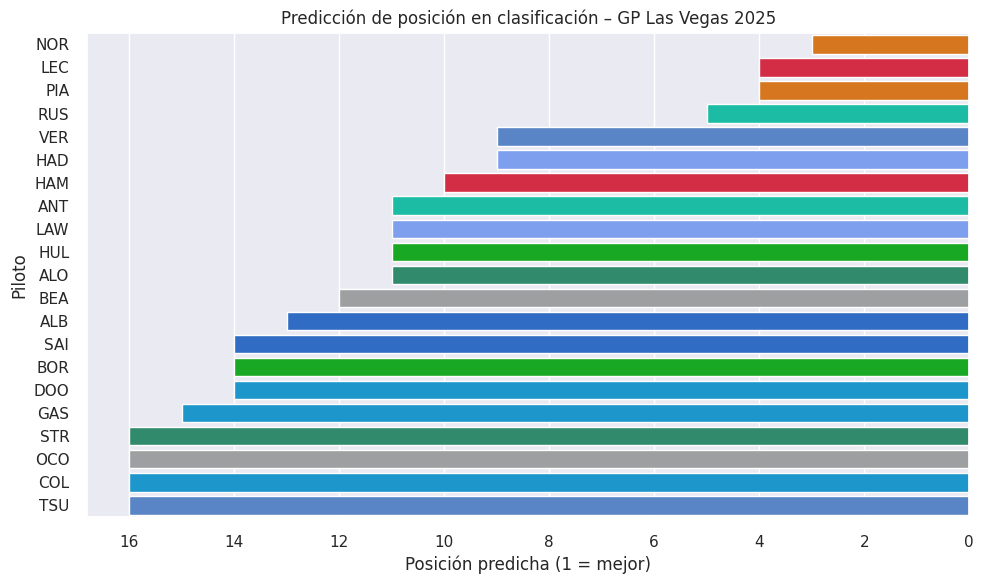

In [ ]:
plt.figure(figsize=(10, 6))

# Ordenado de más rápido (P1) a más lento
plot_df = summary_vegas.copy().sort_values('predicted_quali_P')

sns.barplot(
    data=plot_df,
    x='predicted_quali_P',
    y='Abbreviation',
    hue='Abbreviation',
    palette={
        row['Abbreviation']: TEAM_COLORS.get(row['TeamName'], '#777777')
        for _, row in plot_df.iterrows()
    },
    dodge=False,
    legend=False,
    errorbar=None
)

plt.title("Predicción de posición en clasificación – GP Las Vegas 2025")
plt.xlabel("Posición predicha (1 = mejor)")
plt.ylabel("Piloto")
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()


In [ ]:
top10_vegas = summary_vegas.sort_values('predicted_quali_position').head(10).copy()
top10_vegas['predicted_quali_P'] = top10_vegas['predicted_quali_P'].astype(int)

top10_vegas[['predicted_quali_P','Abbreviation','TeamName',
             'avg_quali_before','last3_avg_before','trend_before']]


,predicted_quali_P,Abbreviation,TeamName,avg_quali_before,last3_avg_before,trend_before
0,3,NOR,McLaren,3.25,2.666667,-2.000000
1,4,LEC,Ferrari,5.20,4.000000,-2.666667
2,4,PIA,McLaren,3.00,5.666667,-0.333333
3,5,RUS,Mercedes,4.35,3.000000,-0.333333
4,9,VER,Red Bull Racing,3.10,2.666667,1.333333
5,9,HAD,Racing Bulls,10.20,12.333333,0.333333
6,10,HAM,Ferrari,7.50,4.666667,-3.000000
7,11,ANT,Mercedes,8.40,5.666667,0.666667
8,11,LAW,Racing Bulls,13.15,13.000000,4.000000
9,11,HUL,Kick Sauber,15.35,11.666667,-1.333333


## 7. Resultados del modelo final – Predicción de Clasificación GP Las Vegas 2025

Usando el modelo optimizado **model1_best** (MAE ≈ 3.38), se ha generado la predicción de la clasificación para el **Gran Premio de Las Vegas 2025**, basándonos en:

- Forma histórica del piloto (media de quali 2025)
- Rendimiento reciente (últimas 3 qualys)
- Tendencia (mejora/empeora respecto a carreras recientes)
- Nivel medio del equipo
- Diferencia del piloto respecto a su propio equipo

### 📌 Resumen de la parrilla predicha

El modelo identifica un grupo muy compacto en cabeza, con **McLaren y Ferrari** como estructuras más fuertes a una vuelta. Red Bull aparece competitivo, pero menos dominante que en rondas anteriores.

**TOP 5 predicho:**
1. **NOR (McLaren)** – ritmo muy sólido en toda la temporada, tendencia muy positiva  
2. **LEC (Ferrari)** – buena forma reciente, mejora clara  
3. **PIA (McLaren)** – consistente, aunque su media reciente penaliza ligeramente  
4. **RUS (Mercedes)** – Mercedes mantiene progresión estable  
5. **VER (Red Bull Racing)** – ritmo histórico muy fuerte, pero tendencia reciente inestable  

### 📊 Lecturas interesantes del modelo

- **McLaren** coloca a sus dos pilotos en el Top 3, confirmando su fortaleza en circuitos urbanos rápidos.
- **Ferrari** aparece como la principal alternativa: Leclerc con una tendencia muy positiva y Hamilton algo más irregular, pero cerca del Top 10.
- **Mercedes** muestra consistencia: Russell dentro del Top 5 y Antonelli como un sólido P11.
- **Red Bull** sufre una caída relativa comparado con años anteriores: Verstappen aparece en P9 según la tendencia reciente.
- En la zona media, **Haas, Alpine y Kick Sauber** forman un grupo muy igualado.
- La parte final está muy distribuida entre Alpine, Haas, Aston Martin y Kick Sauber.

### 🏁 Parrilla estimada completa

| Pos. Predicha | Piloto | Equipo | Media 2025 | Últimas 3 | Tendencia |
|---|---|---|---|---|---|
| 3 | NOR | McLaren | 3.25 | 2.67 | -2.00 |
| 4 | LEC | Ferrari | 5.20 | 4.00 | -2.67 |
| 4 | PIA | McLaren | 3.00 | 5.67 | -0.33 |
| 5 | RUS | Mercedes | 4.35 | 3.00 | -0.33 |
| 9 | VER | Red Bull | 3.10 | 2.67 | 1.33 |
| 9 | HAD | Racing Bulls | 10.20 | 12.33 | 0.33 |
| 10 | HAM | Ferrari | 7.50 | 4.67 | -3.00 |
| 11 | ANT | Mercedes | 8.40 | 5.67 | 0.67 |
| 11 | LAW | Racing Bulls | 13.15 | 13.00 | 4.00 |
| 11 | HUL | Kick Sauber | 15.35 | 11.67 | -1.33 |
| 11 | ALO | Aston Martin | 10.85 | 11.33 | 1.00 |
| 12 | BEA | Haas | 14.25 | 9.00 | -1.67 |
| 13 | ALB | Williams | 12.50 | 18.33 | -0.67 |
| 14 | SAI | Williams


In [ ]:
def evaluate_gp_prediction(gp_name, year=2025):
    """
    Evalúa el modelo model1_best en un GP concreto del año indicado.

    Parámetros:
        gp_name (str): Nombre (o parte del nombre) del Gran Premio, ej. "São Paulo", "Las Vegas".
        year (int): Año de la temporada (por defecto, 2025).

    Requisitos previos:
        - features_all: dataframe con Year, Round, Event, Abbreviation, TeamName y features del modelo
        - qualy_20XX: dataframe con resultados reales de quali (ej. qualy_2025)
        - model1_best: modelo XGBoost entrenado
        - feature_cols_best: lista de columnas de entrada del modelo
    """
    # 1) Filtrar eventos de ese año que coincidan con el nombre
    mask_gp = (
        (features_all['Year'] == year) &
        (features_all['Event'].str.contains(gp_name, case=False, na=False))
    )

    if mask_gp.sum() == 0:
        print(f"❌ No se ha encontrado ningún evento en {year} cuyo nombre contenga '{gp_name}'.")
        return None

    # Por simplicidad cogemos el primero que encaje
    event_info = features_all[mask_gp].iloc[0]
    gp_event_name = event_info['Event']
    gp_round = int(event_info['Round'])

    print(f"➡ Evaluando GP: '{gp_event_name}' ({year}), Ronda {gp_round}")

    # 2) Construir snapshot ANTES de ese GP (todas las rondas anteriores)
    feat_year_prior = features_all[
        (features_all['Year'] == year) &
        (features_all['Round'] < gp_round)
    ].copy()

    if feat_year_prior.empty:
        print("⚠ No hay rondas anteriores a este GP; no se puede evaluar (sería la primera carrera del año).")
        return None

    feat_year_prior = feat_year_prior.sort_values(['Abbreviation', 'Round'])

    snapshot = (
        feat_year_prior
        .groupby('Abbreviation')
        .tail(1)
        .reset_index(drop=True)
    )

    # 3) Predicción del modelo para este GP
    X_gp = snapshot[feature_cols_best].copy()
    snapshot['predicted_quali_position'] = model1_best.predict(X_gp)
    snapshot['predicted_quali_P'] = snapshot['predicted_quali_position'].round().astype(int)

    # 4) Cargar resultados reales de quali para ese GP
    qualy_name = f"qualy_{year}"
    if qualy_name not in globals():
        raise ValueError(f"No encuentro el dataframe {qualy_name} en el entorno (qualy real de {year}).")

    qualy_df = globals()[qualy_name]
    real_gp = qualy_df[qualy_df['Event'].str.contains(gp_event_name, case=False, na=False)].copy()

    if real_gp.empty:
        print(f"⚠ No hay resultados reales de quali en {qualy_name} para el evento '{gp_event_name}'.")
        return None

    # Detectar columna de posición real
    pos_candidates = [
        c for c in real_gp.columns
        if c.lower() in ['position', 'pos', 'gridposition', 'grid_pos', 'quali_position']
    ]
    if not pos_candidates:
        print("❌ No se ha encontrado una columna de posición en el dataframe de quali.")
        print("Columnas disponibles:", real_gp.columns.tolist())
        return None

    pos_col = pos_candidates[0]
    real_gp['Position_real'] = pd.to_numeric(real_gp[pos_col], errors='coerce')
    real_gp = real_gp.dropna(subset=['Position_real'])
    real_gp['Position_real'] = real_gp['Position_real'].astype(int)

    real_gp = real_gp[['Abbreviation', 'TeamName', 'Position_real']]

    # 5) Merge predicción + realidad
    eval_df = snapshot.merge(
        real_gp,
        on=['Abbreviation', 'TeamName'],
        how='inner'
    )

    if eval_df.empty:
        print("⚠ No hay intersección de pilotos entre snapshot y quali real (algo raro pasa con los datos).")
        return None

    # 6) Métricas
    eval_df['abs_error'] = (eval_df['predicted_quali_P'] - eval_df['Position_real']).abs()
    eval_df['within_2_spots'] = eval_df['abs_error'] <= 2
    eval_df['exact_hit'] = eval_df['abs_error'] == 0

    mae_gp = eval_df['abs_error'].mean()
    acc_within_2 = eval_df['within_2_spots'].mean()
    acc_exact = eval_df['exact_hit'].mean()

    print(f"\n📊 Métricas para {gp_event_name} {year}:")
    print(f"- MAE específico: {mae_gp:.2f} posiciones")
    print(f"- % pilotos con error ≤ 2 posiciones: {acc_within_2:.1%}")
    print(f"- % pilotos con posición exacta: {acc_exact:.1%}\n")

    # 7) Mostrar tabla ordenada por posición real
    display_cols = [
        'Position_real', 'predicted_quali_P',
        'Abbreviation', 'TeamName', 'abs_error'
    ]
    print("Comparativa posición real vs predicha:")
    display(eval_df.sort_values('Position_real')[display_cols])

    return eval_df


In [ ]:
# São Paulo (el que ya probamos)
evaluate_gp_prediction("São Paulo", year=2025)
# Otro GP, por ejemplo "Monaco"
evaluate_gp_prediction("Monaco", year=2025)

# Las Vegas (cuando tengas la quali real disponible)
evaluate_gp_prediction("Las Vegas", year=2025)



➡ Evaluando GP: 'São Paulo Grand Prix' (2025), Ronda 21

📊 Métricas para São Paulo Grand Prix 2025:
- MAE específico: 4.05 posiciones
- % pilotos con error ≤ 2 posiciones: 31.6%
- % pilotos con posición exacta: 5.3%

Comparativa posición real vs predicha:


/tmp/ipython-input-1023740223.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_gp['Position_real'] = real_gp['Position_real'].astype(int)


,Position_real,predicted_quali_P,Abbreviation,TeamName,abs_error
11,1,2,NOR,McLaren,1
2,2,7,ANT,Mercedes,5
10,3,6,LEC,Ferrari,3
13,4,6,PIA,McLaren,2
6,5,10,HAD,Racing Bulls,5
14,6,4,RUS,Mercedes,2
9,7,14,LAW,Racing Bulls,7
3,8,11,BEA,Haas F1 Team,3
5,9,17,GAS,Alpine,8
8,10,13,HUL,Kick Sauber,3


➡ Evaluando GP: 'Monaco Grand Prix' (2025), Ronda 8

📊 Métricas para Monaco Grand Prix 2025:
- MAE específico: 3.80 posiciones
- % pilotos con error ≤ 2 posiciones: 45.0%
- % pilotos con posición exacta: 10.0%

Comparativa posición real vs predicha:


,Position_real,predicted_quali_P,Abbreviation,TeamName,abs_error
12,1,3,NOR,McLaren,2
11,2,8,LEC,Ferrari,6
14,3,3,PIA,McLaren,0
8,4,9,HAM,Ferrari,5
19,5,4,VER,Red Bull Racing,1
7,6,11,HAD,Racing Bulls,5
1,7,9,ALO,Aston Martin,2
13,8,17,OCO,Haas F1 Team,9
10,9,14,LAW,Racing Bulls,5
0,10,10,ALB,Williams,0


❌ No se ha encontrado ningún evento en 2025 cuyo nombre contenga 'Las Vegas'.


## 10. Mejorando el modelo con datos reales del fin de semana: FP1–FP3

El mayor salto de precisión en predicción de clasificación ocurre al incorporar
los datos de las sesiones libres del propio Gran Premio:

- FP1 → primeras sensaciones, setup base
- FP2 → ritmo representativo con neumáticos usados
- FP3 → simulación de quali, el indicador más fuerte

En esta sección:
1. Descargamos automáticamente FP1, FP2 y FP3.
2. Generamos nuevas features por piloto:
   - mejor vuelta FP1/FP2/FP3
   - gap al líder
   - ritmo medio
   - ideal lap (suma de mejores sectores)
3. Combinamos todo con el dataset de forma histórica.
4. Entrenamos un nuevo modelo mucho más preciso.
